In [1]:
import math
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda') if USE_CUDA else torch.device('cpu')

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
%matplotlib inline

In [3]:
def prep_data(basket):
    historicals = {}
    for symbol in basket:
        if symbol in datas:
            historicals[symbol] = datas[symbol]
        else:
            payload = { 'symbols' : symbol,
                        'interval' : 'day',
                        'span' : '5year',
                        'bounds' : 'regular'}
            historicals[symbol] = r.request_get('https://api.robinhood.com/quotes/historicals/', 'results', payload)[0]['historicals']
            datas[symbol] = historicals[symbol]
    hs = {}
    all_h = []
    for symbol in basket:
        h = [float(h['close_price']) for h in historicals[symbol]]
        lens[symbol] = len(h)
        all_h += h
    nph = np.array(all_h).reshape(-1, 1)
    for symbol in basket:
        means[symbol] = 0
    scaler = StandardScaler()
    scaler.fit(nph)
    for symbol in basket:
        scalers[symbol] = scaler

## If loading saved data:

In [4]:
[scalers, means, lens, datas] = pickle.load(open('saved_rh_rokuuber.pkl', 'rb'))
prep_data(['NVDA', 'MSFT', 'EAT', 'AAPL', 'F', 'STM', 'MCD', 'WMT',
           'V', 'DIS', 'PG', 'XOM', 'PFE', 'KO', 'MRK', 'GS', 'NKE', 'MMM',
           'CVX', 'UNH', 'BA', 'TRV', 'UTX', 'IBM', 'AXP', 'MS', 'JPM'])

## If instead fetch new data from Robinhood:

In [ ]:
import robin_stocks as r
r.login('**@gmail.com', '*password_goes_here*')

In [19]:
scalers = {}
means = {}
lens = {}
datas = {}
prep_data(['STM', 'EAT', 'MSFT', 'NVDA', 'TSLA', 'F', 'NXPI', 'SQ', 'UBER', 'AAPL', 'TWTR', 'NFLX',
             'FB', 'DIS', 'SBUX', 'BABA', 'BAC', 'FIT', 'GE', 'ACB', 'GREK', 'AMZN', 'GOOGL', 'INTC',
             'TXN', 'QCOM', 'ROKU', 'TSN', 'T'])
pickle.dump([scalers, means, lens, datas], open('saved_rh.pkl', 'wb'))

## Continue here once data is prepared

In [5]:
class EncoderDecoder(nn.Module):
    
    def __init__(self, encoder, decoder, hidden_size):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.dropout_layer = nn.Dropout(0.1)
        self.output_layer = nn.Linear(hidden_size, 1, bias=False)
        
    def forward(self, src, trg, src_lengths, trg_lengths):
        encoder_hidden, encoder_final = self.encode(src, src_lengths)
        return self.decode(encoder_hidden, encoder_final, trg)
    
    def encode(self, src, src_lengths):
        return self.encoder(src.to(torch.float).unsqueeze(-1), src_lengths)
    
    def decode(self, encoder_hidden, encoder_final, trg, decoder_hidden=None):
        trg = trg.to(torch.float).unsqueeze(-1)
        decoded = self.decoder(trg, encoder_hidden, encoder_final, hidden=decoder_hidden)
        return decoded[0], decoded[1], self.output_layer(self.dropout_layer(decoded[0]))

In [6]:
class Encoder(nn.Module):
    def __init__(self, hidden_size, num_layers=1, dropout=0.):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.rnn = nn.GRU(1, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        
    def forward(self, x, lengths):
        output, final_hidden = self.rnn(x)
        fwd_final = final_hidden[0:final_hidden.size(0):2]
        bwd_final = final_hidden[1:final_hidden.size(0):2]
        final = torch.cat([fwd_final, bwd_final], dim=2)
        return output, final

In [7]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, num_layers=1, dropout=0.5):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        emb_size = 1
        self.attention = AttentionMechanism(hidden_size)
                 
        self.rnn = nn.GRU(emb_size + 2*hidden_size, hidden_size, num_layers,
                          batch_first=True, dropout=dropout)
                 
        self.bridge = nn.Linear(2*hidden_size, hidden_size, bias=True)

        self.dropout_layer = nn.Dropout(self.dropout)
        self.pre_output_layer = nn.Linear(hidden_size + 2*hidden_size + emb_size,
                                          hidden_size, bias=False)
        
    def forward_step(self, prev_embed, encoder_hidden, proj_key, hidden):
        query = hidden[-1].unsqueeze(1)
        context, attn_probs = self.attention(
            query=query, proj_key=proj_key,
            value=encoder_hidden)

        rnn_input = torch.cat([prev_embed, context], dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        
        pre_output = torch.cat([prev_embed, output, context], dim=2)
        pre_output = self.dropout_layer(pre_output)
        pre_output = self.pre_output_layer(pre_output)

        return output, hidden, pre_output
    
    def forward(self, trg, encoder_hidden, encoder_final, hidden=None):
        max_len = trg.size(1)

        if hidden is None:
            if encoder_final is not None:
                hidden = torch.tanh(self.bridge(encoder_final))
            
        proj_key = self.attention.key_layer(encoder_hidden)
        
        decoder_states = []
        pre_output_vectors = []
        
        for i in range(max_len):
            prev_embed = trg[:, i].unsqueeze(1)
            output, hidden, pre_output = self.forward_step(
              prev_embed, encoder_hidden, proj_key, hidden)
            decoder_states.append(output)
            pre_output_vectors.append(pre_output)

        decoder_states = torch.cat(decoder_states, dim=1)
        pre_output_vectors = torch.cat(pre_output_vectors, dim=1)
        return decoder_states, hidden, pre_output_vectors

In [8]:
class AttentionMechanism(nn.Module):
    
    def __init__(self, hidden_size, key_size=None, query_size=None):
        super(AttentionMechanism, self).__init__()
        key_size = 2 * hidden_size if key_size is None else key_size
        query_size = hidden_size if query_size is None else query_size
        self.key_layer = nn.Linear(key_size, hidden_size, bias=False)
        self.query_layer = nn.Linear(query_size, hidden_size, bias=False)
        self.energy_layer = nn.Linear(hidden_size, 1, bias=False)
        self.alphas = []
        
    def forward(self, query=None, proj_key=None, value=None):
        query = self.query_layer(query)
        scores = self.energy_layer(torch.tanh(query + proj_key))
        scores = scores.squeeze(2).unsqueeze(1)
        alphas = F.softmax(scores, dim=-1)
        self.alphas.append(alphas.detach().cpu().numpy())
        self.alphas = self.alphas[-5:]
        context = torch.bmm(alphas, value)
        
        return context, alphas

In [9]:
class Batch:
    def __init__(self, src, trg, symbol=''):
        src, src_lengths = src
        
        self.src = src
        self.src_lengths = src_lengths
        self.batch_size = src.size(0)
        
        self.trg = None
        self.trg_lengths = None
        self.total_tokens = None
        
        self.symbol = symbol

        if trg is not None:
            trg, trg_lengths = trg
            self.trg = trg
            self.trg_lengths = trg_lengths
            self.total_tokens = self.batch_size * self.trg.size(-1)
        
        if USE_CUDA:
            self.src = self.src.cuda()

            if trg is not None:
                self.trg = self.trg.cuda()

In [10]:
def print_examples(example_iter, model, n=1, symbol='AAPL', latest=False):
    model.eval()
    count = 0
    if symbol not in lens:
        _ = next(example_iter)
    start = max(0, random.randint(0, lens[symbol]) - n)
    for i, batch in enumerate(example_iter):
        if not latest and i < start:
            continue
        with torch.no_grad():
            out, _, y_hat = model.forward(batch.src, batch.trg,
                                          batch.src_lengths, batch.trg_lengths)
        y_hat = y_hat.cpu()
        j = 0
        y_hat_single = scalers[symbol].inverse_transform(y_hat[j].view(1,-1)) + means[symbol]
        print("Example: %d" % (i+1))
        print("Prediction: ", [float('{:.2f}'.format(x)) for x in y_hat_single[0].tolist()])
        if not latest:
            target = scalers[symbol].inverse_transform(batch.trg[j].cpu().view(1, -1)) + means[symbol]
            target = target[0]
            target = np.round(target, 3).tolist()
            print("Actual: ", [float('{:.2f}'.format(x)) for x in target])
        else:
            last_prices = scalers[symbol].inverse_transform(batch.src[j].cpu().view(1, -1)) + means[symbol]
            last_prices = last_prices[0]
            last_prices = np.round(last_prices, 3).tolist()
            print("Last 50 prices: ", [float('{:.2f}'.format(x)) for x in last_prices])
        count += 1
        if not latest:#last_prices:
            last_prices = [0]
        if count == n:
            break
    return y_hat_single[0].tolist(), last_prices

In [11]:
def data_gen(batch_size=1, basket=['NVDA'], for_prediction=False, reserve_for_backtesting=False,
            output_seq_length=10):
    historicals = {}
    for symbol in basket:
        if symbol in datas:
            historicals[symbol] = datas[symbol]
        else:
            payload = { 'symbols' : symbol,
                        'interval' : 'day',
                        'span' : '5year',
                        'bounds' : 'regular'}
            historicals[symbol] = r.request_get('https://api.robinhood.com/quotes/historicals/', 'results', payload)[0]['historicals']
            datas[symbol] = historicals[symbol]
            
    if reserve_for_backtesting:
        if not for_prediction:
            for symbol in basket:
                historicals[symbol] = historicals[symbol][:-reserve_for_backtesting]
                print(symbol + ' - ' + historicals[symbol][-1]['begins_at'])
        if for_prediction:
            for symbol in basket:
                last_date = historicals[symbol][-reserve_for_backtesting+1+output_seq_length]['begins_at']
                historicals[symbol] = historicals[symbol][-reserve_for_backtesting-50:-reserve_for_backtesting+1]
                print(symbol + ' - ' + historicals[symbol][-1]['begins_at'])
                print('The last prediction will be for - ' + last_date)
    
    hs = {}
    for symbol in basket:
        h = [float(h['close_price']) for h in historicals[symbol]]
        nph = np.array(h).reshape(-1, 1)
        if symbol not in means:
            means[symbol] = nph.mean()
        nph -= means[symbol]
        if symbol not in scalers:
            scalers[symbol] = StandardScaler()
            hs[symbol] = list(scalers[symbol].fit_transform(nph).reshape(-1))
        else:
            hs[symbol] = list(scalers[symbol].transform(nph).reshape(-1))
    
        
    if for_prediction:
        training_set = [
            (hs[basket[0]][i-50:i], hs[symbol][i-output_seq_length:i], symbol) for i in range(50, len(historicals[basket[0]]))
        ]
        if symbol not in lens:
            lens[symbol] = len(training_set)
    else:
        training_set = []
        for symbol in basket:
            my_sym = [
                (hs[symbol][i-50:i], hs[symbol][i:i+output_seq_length], symbol) for i in range(50, len(historicals[symbol]) - output_seq_length)
            ]
            lens[symbol] = len(my_sym)
            for asd in my_sym:
                training_set.append(asd)
        random.shuffle(training_set)
    if for_prediction:
        batch_size = 1
    for i in range(len(training_set)):
        minibatch_src = []
        minibatch_trg = []
        for j in range(batch_size):
            if not for_prediction:
                sample = random.sample(training_set, k=1)[0] #TODO simplify with k=batch_size
            else:
                sample = training_set[-1]
            minibatch_src.append(sample[0]) #Leaving off the symbol
            minibatch_trg.append(sample[1])
        minibatch_src = np.array(minibatch_src)
        minibatch_trg = np.array(minibatch_trg)
        data = torch.tensor(minibatch_src, dtype=torch.float32)
        data = data.cuda() if USE_CUDA else data

        trg = torch.tensor(minibatch_trg, dtype=torch.float32)
        trg = trg.cuda() if USE_CUDA else trg
        
        data_lengths = [data.size(-1)] * batch_size
        trg_lengths = [trg.size(-1)] * batch_size
        yield Batch((data, data_lengths), (trg, trg_lengths), symbol='TODO')

In [12]:
hidden_size = 128; num_layers = 2; dropout = 0.2;

model = EncoderDecoder(
    Encoder(hidden_size, num_layers=num_layers, dropout=dropout),
    Decoder(hidden_size, num_layers=num_layers, dropout=dropout),
    hidden_size)
model = model.cuda() if USE_CUDA else model
criterion = nn.MSELoss()#L1Loss()
optim = torch.optim.Adam(model.parameters(), lr=0.00005)
if USE_CUDA:
    model.cuda()

In [13]:
def run_epoch(data_iter, model, print_every=50, is_training=False):
    total_tokens = 0
    total_loss = 0
    for i, batch in enumerate(data_iter):
        out, _, y_hat = model.forward(batch.src, batch.trg, batch.src_lengths, batch.trg_lengths)
        loss = criterion(y_hat, batch.trg.unsqueeze(-1))
        loss = loss / batch.batch_size
        if is_training:
            loss.backward()
            optim.step()
            optim.zero_grad()
        total_loss += loss
        total_tokens += batch.total_tokens
        if model.training and i % print_every == 0:
            print("Step: %d Loss: %f" % (i, loss / batch.batch_size))
    return math.exp(total_loss / float(total_tokens))

In [14]:
for epoch in range(5):
    data = data_gen(batch_size=4, basket=['STM', 'EAT', 'MSFT', 'NVDA', 'TSLA', 'F', 'NXPI', 'SQ', 'UBER', 'AAPL', 'TWTR', 'NFLX',
             'FB', 'DIS', 'SBUX', 'BABA', 'BAC', 'FIT', 'GE', 'ACB', 'GREK', 'AMZN', 'GOOGL', 'INTC',
             'TXN', 'QCOM', 'ROKU', 'TSN', 'T'], output_seq_length=5)
    #['STM', 'EAT', 'MSFT', 'NVDA', 'TSLA', 'F', 'NXPI', 'SQ', 'UBER'], output_seq_length=5)
    # , 'AAPL', 'MSFT', 'STM', EAT', 'MCD', 'WMT', 'V', 'DIS', 'PG', 'XOM', 'PFE', 'KO', 'MRK', 'GS', 'NKE', 'MMM', 'CVX', 'UNH', 'BA', 'TRV', 'UTX'
    eval_data = data_gen(basket=['UBER'], output_seq_length=5)
    test_data = data_gen(batch_size=2, basket=['STM'], output_seq_length=5)
    
    print("Epoch %d" % epoch)
    model.train()    
    run_epoch(data, model, is_training=True)
    model.eval()
    with torch.no_grad():
        run_epoch(eval_data, model)
        print_examples(test_data, model, n=2, symbol='F')

Epoch 0
Step: 0 Loss: 0.055143
Step: 50 Loss: 0.006823
Step: 100 Loss: 0.008016
Step: 150 Loss: 0.000792
Step: 200 Loss: 0.000491
Step: 250 Loss: 0.000213
Step: 300 Loss: 0.000237
Step: 350 Loss: 0.000919
Step: 400 Loss: 0.070667
Step: 450 Loss: 0.000229
Step: 500 Loss: 0.000602
Step: 550 Loss: 0.001142
Step: 600 Loss: 0.001315
Step: 650 Loss: 0.000140
Step: 700 Loss: 0.000425
Step: 750 Loss: 0.000561
Step: 800 Loss: 0.000099
Step: 850 Loss: 0.000039
Step: 900 Loss: 0.000388
Step: 950 Loss: 0.000777
Step: 1000 Loss: 0.000075
Step: 1050 Loss: 0.000310
Step: 1100 Loss: 0.000235
Step: 1150 Loss: 0.000715
Step: 1200 Loss: 0.000265
Step: 1250 Loss: 0.000595
Step: 1300 Loss: 0.000152
Step: 1350 Loss: 0.000492
Step: 1400 Loss: 0.000095
Step: 1450 Loss: 0.000345
Step: 1500 Loss: 0.001408
Step: 1550 Loss: 0.000669
Step: 1600 Loss: 0.000064
Step: 1650 Loss: 0.000602
Step: 1700 Loss: 0.000214
Step: 1750 Loss: 0.000402
Step: 1800 Loss: 0.000604
Step: 1850 Loss: 0.000219
Step: 1900 Loss: 0.000189
S

Step: 15600 Loss: 0.000020
Step: 15650 Loss: 0.000187
Step: 15700 Loss: 0.000016
Step: 15750 Loss: 0.000085
Step: 15800 Loss: 0.000057
Step: 15850 Loss: 0.000022
Step: 15900 Loss: 0.000018
Step: 15950 Loss: 0.000051
Step: 16000 Loss: 0.000084
Step: 16050 Loss: 0.000131
Step: 16100 Loss: 0.003831
Step: 16150 Loss: 0.000370
Step: 16200 Loss: 0.000043
Step: 16250 Loss: 0.000380
Step: 16300 Loss: 0.000027
Step: 16350 Loss: 0.000077
Step: 16400 Loss: 0.000230
Step: 16450 Loss: 0.000067
Step: 16500 Loss: 0.000027
Step: 16550 Loss: 0.000035
Step: 16600 Loss: 0.000027
Step: 16650 Loss: 0.000786
Step: 16700 Loss: 0.000064
Step: 16750 Loss: 0.000047
Step: 16800 Loss: 0.000017
Step: 16850 Loss: 0.000015
Step: 16900 Loss: 0.000154
Step: 16950 Loss: 0.000419
Step: 17000 Loss: 0.000808
Step: 17050 Loss: 0.000247
Step: 17100 Loss: 0.000023
Step: 17150 Loss: 0.000057
Step: 17200 Loss: 0.000026
Step: 17250 Loss: 0.000089
Step: 17300 Loss: 0.000123
Step: 17350 Loss: 0.000032
Step: 17400 Loss: 0.000048
S

Step: 30800 Loss: 0.000991
Step: 30850 Loss: 0.003466
Step: 30900 Loss: 0.000057
Step: 30950 Loss: 0.000046
Step: 31000 Loss: 0.000058
Step: 31050 Loss: 0.000014
Step: 31100 Loss: 0.000025
Step: 31150 Loss: 0.000249
Step: 31200 Loss: 0.000050
Step: 31250 Loss: 0.000353
Step: 31300 Loss: 0.000068
Step: 31350 Loss: 0.000010
Step: 31400 Loss: 0.000012
Step: 31450 Loss: 0.000014
Step: 31500 Loss: 0.000270
Step: 31550 Loss: 0.000034
Step: 31600 Loss: 0.000682
Step: 31650 Loss: 0.000098
Step: 31700 Loss: 0.000044
Step: 31750 Loss: 0.000050
Step: 31800 Loss: 0.000855
Step: 31850 Loss: 0.000116
Step: 31900 Loss: 0.000095
Step: 31950 Loss: 0.000088
Step: 32000 Loss: 0.000013
Step: 32050 Loss: 0.000345
Step: 32100 Loss: 0.000218
Step: 32150 Loss: 0.000695
Step: 32200 Loss: 0.000235
Step: 32250 Loss: 0.000018
Step: 32300 Loss: 0.001088
Step: 32350 Loss: 0.000071
Step: 32400 Loss: 0.000905
Step: 32450 Loss: 0.000055
Step: 32500 Loss: 0.000195
Step: 32550 Loss: 0.000040
Step: 32600 Loss: 0.000349
S

Step: 11000 Loss: 0.000015
Step: 11050 Loss: 0.000139
Step: 11100 Loss: 0.000010
Step: 11150 Loss: 0.000043
Step: 11200 Loss: 0.000040
Step: 11250 Loss: 0.000221
Step: 11300 Loss: 0.000057
Step: 11350 Loss: 0.000033
Step: 11400 Loss: 0.000775
Step: 11450 Loss: 0.000242
Step: 11500 Loss: 0.000050
Step: 11550 Loss: 0.000196
Step: 11600 Loss: 0.000044
Step: 11650 Loss: 0.000057
Step: 11700 Loss: 0.000120
Step: 11750 Loss: 0.000019
Step: 11800 Loss: 0.000006
Step: 11850 Loss: 0.000124
Step: 11900 Loss: 0.000127
Step: 11950 Loss: 0.000013
Step: 12000 Loss: 0.000022
Step: 12050 Loss: 0.000298
Step: 12100 Loss: 0.000060
Step: 12150 Loss: 0.000313
Step: 12200 Loss: 0.000274
Step: 12250 Loss: 0.000082
Step: 12300 Loss: 0.000031
Step: 12350 Loss: 0.000042
Step: 12400 Loss: 0.000018
Step: 12450 Loss: 0.000235
Step: 12500 Loss: 0.000723
Step: 12550 Loss: 0.000016
Step: 12600 Loss: 0.000113
Step: 12650 Loss: 0.000031
Step: 12700 Loss: 0.000015
Step: 12750 Loss: 0.000016
Step: 12800 Loss: 0.000012
S

Step: 26200 Loss: 0.000188
Step: 26250 Loss: 0.000095
Step: 26300 Loss: 0.000128
Step: 26350 Loss: 0.000016
Step: 26400 Loss: 0.000073
Step: 26450 Loss: 0.000051
Step: 26500 Loss: 0.000115
Step: 26550 Loss: 0.000104
Step: 26600 Loss: 0.000008
Step: 26650 Loss: 0.000022
Step: 26700 Loss: 0.000015
Step: 26750 Loss: 0.000058
Step: 26800 Loss: 0.000032
Step: 26850 Loss: 0.000016
Step: 26900 Loss: 0.000025
Step: 26950 Loss: 0.000033
Step: 27000 Loss: 0.000056
Step: 27050 Loss: 0.000163
Step: 27100 Loss: 0.000016
Step: 27150 Loss: 0.000026
Step: 27200 Loss: 0.000009
Step: 27250 Loss: 0.000005
Step: 27300 Loss: 0.000025
Step: 27350 Loss: 0.000022
Step: 27400 Loss: 0.000103
Step: 27450 Loss: 0.000564
Step: 27500 Loss: 0.000215
Step: 27550 Loss: 0.000040
Step: 27600 Loss: 0.000018
Step: 27650 Loss: 0.000027
Step: 27700 Loss: 0.000107
Step: 27750 Loss: 0.000027
Step: 27800 Loss: 0.000010
Step: 27850 Loss: 0.000172
Step: 27900 Loss: 0.000027
Step: 27950 Loss: 0.001147
Step: 28000 Loss: 0.000024
S

Step: 6250 Loss: 0.000112
Step: 6300 Loss: 0.000031
Step: 6350 Loss: 0.000011
Step: 6400 Loss: 0.000029
Step: 6450 Loss: 0.000006
Step: 6500 Loss: 0.000014
Step: 6550 Loss: 0.000010
Step: 6600 Loss: 0.000019
Step: 6650 Loss: 0.000031
Step: 6700 Loss: 0.000057
Step: 6750 Loss: 0.000014
Step: 6800 Loss: 0.000007
Step: 6850 Loss: 0.000160
Step: 6900 Loss: 0.000014
Step: 6950 Loss: 0.000281
Step: 7000 Loss: 0.000048
Step: 7050 Loss: 0.000013
Step: 7100 Loss: 0.000035
Step: 7150 Loss: 0.000085
Step: 7200 Loss: 0.000036
Step: 7250 Loss: 0.000044
Step: 7300 Loss: 0.000019
Step: 7350 Loss: 0.000044
Step: 7400 Loss: 0.000063
Step: 7450 Loss: 0.000055
Step: 7500 Loss: 0.000064
Step: 7550 Loss: 0.000206
Step: 7600 Loss: 0.000733
Step: 7650 Loss: 0.000052
Step: 7700 Loss: 0.000009
Step: 7750 Loss: 0.000073
Step: 7800 Loss: 0.000377
Step: 7850 Loss: 0.000078
Step: 7900 Loss: 0.000326
Step: 7950 Loss: 0.000034
Step: 8000 Loss: 0.000123
Step: 8050 Loss: 0.000042
Step: 8100 Loss: 0.000031
Step: 8150 L

Step: 21600 Loss: 0.000157
Step: 21650 Loss: 0.000039
Step: 21700 Loss: 0.000052
Step: 21750 Loss: 0.000086
Step: 21800 Loss: 0.000032
Step: 21850 Loss: 0.000030
Step: 21900 Loss: 0.000327
Step: 21950 Loss: 0.000009
Step: 22000 Loss: 0.000014
Step: 22050 Loss: 0.000030
Step: 22100 Loss: 0.000019
Step: 22150 Loss: 0.000831
Step: 22200 Loss: 0.000007
Step: 22250 Loss: 0.000016
Step: 22300 Loss: 0.000049
Step: 22350 Loss: 0.000014
Step: 22400 Loss: 0.000044
Step: 22450 Loss: 0.000132
Step: 22500 Loss: 0.000010
Step: 22550 Loss: 0.000042
Step: 22600 Loss: 0.000050
Step: 22650 Loss: 0.000009
Step: 22700 Loss: 0.000078
Step: 22750 Loss: 0.000250
Step: 22800 Loss: 0.000024
Step: 22850 Loss: 0.000010
Step: 22900 Loss: 0.000027
Step: 22950 Loss: 0.000010
Step: 23000 Loss: 0.000050
Step: 23050 Loss: 0.000005
Step: 23100 Loss: 0.000103
Step: 23150 Loss: 0.000008
Step: 23200 Loss: 0.000049
Step: 23250 Loss: 0.000058
Step: 23300 Loss: 0.000058
Step: 23350 Loss: 0.000053
Step: 23400 Loss: 0.000034
S

Step: 1500 Loss: 0.000014
Step: 1550 Loss: 0.000470
Step: 1600 Loss: 0.000139
Step: 1650 Loss: 0.000099
Step: 1700 Loss: 0.000066
Step: 1750 Loss: 0.000016
Step: 1800 Loss: 0.000032
Step: 1850 Loss: 0.000015
Step: 1900 Loss: 0.000033
Step: 1950 Loss: 0.000052
Step: 2000 Loss: 0.000019
Step: 2050 Loss: 0.000028
Step: 2100 Loss: 0.000014
Step: 2150 Loss: 0.000061
Step: 2200 Loss: 0.000036
Step: 2250 Loss: 0.000080
Step: 2300 Loss: 0.000038
Step: 2350 Loss: 0.000019
Step: 2400 Loss: 0.000016
Step: 2450 Loss: 0.000022
Step: 2500 Loss: 0.000071
Step: 2550 Loss: 0.000115
Step: 2600 Loss: 0.000037
Step: 2650 Loss: 0.000034
Step: 2700 Loss: 0.000153
Step: 2750 Loss: 0.000067
Step: 2800 Loss: 0.000005
Step: 2850 Loss: 0.000029
Step: 2900 Loss: 0.000126
Step: 2950 Loss: 0.000145
Step: 3000 Loss: 0.000264
Step: 3050 Loss: 0.000082
Step: 3100 Loss: 0.000091
Step: 3150 Loss: 0.000051
Step: 3200 Loss: 0.000048
Step: 3250 Loss: 0.000792
Step: 3300 Loss: 0.000008
Step: 3350 Loss: 0.000113
Step: 3400 L

KeyboardInterrupt: 

In [21]:
for stock in ['STM', 'EAT', 'MSFT', 'NVDA', 'TSLA', 'F', 'NXPI', 'SQ', 'UBER', 'AAPL', 'TWTR', 'NFLX',
             'FB', 'DIS', 'SBUX', 'BABA', 'BAC', 'FIT', 'GE', 'ACB', 'GREK', 'AMZN', 'GOOGL', 'INTC',
             'TXN', 'QCOM', 'ROKU', 'TSN', 'T']:
    foof = data_gen(basket=[stock], for_prediction=True, output_seq_length=5)
    pred, last_ = print_examples(foof, model, symbol=stock, latest=True)
    print("stock: {}, gain: {}".format(stock, pred[-1] / last_[-1]))

Example: 1
Prediction:  [14.82, 14.98, 15.01, 14.92, 15.3]
Last 50 prices:  [17.15, 16.98, 17.02, 16.59, 17.12, 17.51, 17.62, 18.35, 18.02, 18.01, 17.69, 17.5, 17.47, 17.66, 17.65, 17.86, 17.8, 17.67, 17.78, 18.08, 18.19, 18.57, 19.03, 19.45, 19.02, 19.15, 19.1, 18.65, 18.25, 17.97, 17.55, 16.82, 16.94, 17.06, 17.56, 17.73, 17.56, 18.11, 17.16, 17.28, 17.5, 18.0, 17.97, 18.18, 18.04, 17.12, 17.44, 17.45, 17.27, 17.68]
stock: STM, gain: 0.8652149133084169
Example: 1
Prediction:  [36.55, 36.53, 36.48, 36.3, 36.48]
Last 50 prices:  [38.23, 37.87, 37.31, 38.28, 38.31, 39.04, 39.35, 38.98, 39.13, 38.67, 39.42, 38.83, 38.72, 38.1, 38.38, 38.7, 39.65, 39.84, 39.72, 39.57, 39.62, 40.57, 40.14, 40.4, 38.64, 39.92, 40.71, 40.47, 39.85, 40.21, 40.92, 39.7, 39.4, 38.22, 39.66, 39.94, 39.86, 38.64, 37.01, 37.02, 38.46, 39.69, 38.04, 39.36, 40.34, 38.64, 38.36, 38.38, 38.19, 38.51]
stock: EAT, gain: 0.9473131939893998
Example: 1
Prediction:  [134.19, 135.95, 136.53, 136.16, 137.67]
Last 50 prices:  

## Some examples for sanity checking

In [19]:
foof = data_gen(basket=['STM'], for_prediction=True, reserve_for_backtesting=15)
print_examples(foof, model, symbol='STM', latest=True)

STM - 2019-08-01T00:00:00Z
The last prediction will be for - 2019-08-16T00:00:00Z
Example: 1
Prediction:  [18.16, 18.15, 18.21, 18.51, 19.03, 19.35, 19.76, 20.16, 20.36, 20.43]
Last 50 prices:  [16.36, 16.06, 15.45, 15.24, 15.1, 15.16, 15.11, 15.04, 15.16, 15.98, 15.62, 15.63, 16.52, 16.34, 16.68, 16.29, 16.54, 15.81, 15.59, 16.11, 16.58, 17.15, 16.98, 17.02, 16.59, 17.12, 17.51, 17.62, 18.35, 18.02, 18.01, 17.69, 17.5, 17.47, 17.66, 17.65, 17.86, 17.8, 17.67, 17.78, 18.08, 18.19, 18.57, 19.03, 19.45, 19.02, 19.15, 19.1, 18.65, 18.25]


In [20]:
foof = data_gen(basket=['F'], for_prediction=True)
print_examples(foof, model, symbol='F', latest=True)

Example: 1
Prediction:  [9.18, 9.33, 9.3, 9.32, 9.53, 9.78, 10.1, 10.54, 11.02, 11.44]
Last 50 prices:  [9.92, 9.85, 10.06, 9.98, 10.05, 10.1, 10.04, 10.04, 9.99, 9.95, 9.84, 9.91, 10.2, 10.23, 10.15, 10.12, 10.2, 10.2, 10.2, 10.14, 10.11, 10.19, 10.49, 10.42, 10.51, 10.33, 10.26, 10.2, 10.02, 10.17, 10.33, 9.56, 9.57, 9.6, 9.55, 9.53, 9.31, 9.28, 9.23, 9.48, 9.53, 9.56, 9.45, 9.29, 9.26, 9.0, 8.86, 8.96, 9.03, 8.96]


In [21]:
foof = data_gen(basket=['NVDA'], for_prediction=True, reserve_for_backtesting=12)
print_examples(foof, model, symbol='NVDA', latest=True)

NVDA - 2019-08-06T00:00:00Z
The last prediction will be for - 2019-08-21T00:00:00Z
Example: 1
Prediction:  [172.74, 177.08, 172.36, 173.2, 173.35, 174.14, 168.58, 164.9, 161.54, 152.26]
Last 50 prices:  [145.15, 143.33, 140.34, 139.11, 135.46, 133.78, 143.0, 141.28, 143.78, 145.5, 148.43, 150.75, 146.2, 148.26, 144.64, 145.03, 152.88, 153.12, 154.1, 151.76, 152.66, 151.48, 159.26, 163.23, 164.23, 166.17, 162.23, 162.75, 160.23, 157.21, 157.31, 160.06, 166.28, 167.61, 167.27, 167.08, 169.71, 170.18, 168.44, 171.32, 175.66, 178.66, 173.38, 175.07, 174.82, 175.45, 168.72, 164.92, 161.19, 150.79]


In [22]:
foof = data_gen(basket=['EAT'], for_prediction=True)
print_examples(foof, model, symbol='EAT', latest=True)

Example: 1
Prediction:  [38.14, 38.85, 39.21, 39.36, 38.94, 38.04, 37.69, 38.33, 39.37, 39.16]
Last 50 prices:  [39.95, 40.5, 40.15, 39.54, 39.98, 38.8, 38.08, 38.23, 37.87, 37.31, 38.28, 38.31, 39.04, 39.35, 38.98, 39.13, 38.67, 39.42, 38.83, 38.72, 38.1, 38.38, 38.7, 39.65, 39.84, 39.72, 39.57, 39.62, 40.57, 40.14, 40.4, 38.64, 39.92, 40.71, 40.47, 39.85, 40.21, 40.92, 39.7, 39.4, 38.22, 39.66, 39.94, 39.86, 38.64, 37.01, 37.02, 38.46, 39.69, 38.04]


In [15]:
alphas = model.decoder.attention.alphas
alphas = np.array(alphas)

In [16]:
alphas.shape

(5, 4, 1, 50)

In [28]:
alphas2 = alphas[:,0,:,:].reshape(5,50) # First of batch
z = []
for i in range(5):
    z.append(alphas2[i]**2)

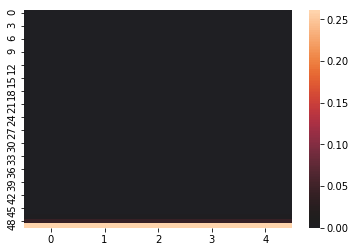

In [29]:
sns.heatmap(np.array(z).T, center=0.01)

In [16]:
datas['ROKU'][-1]

{'begins_at': '2019-08-21T00:00:00Z',
 'open_price': '134.260000',
 'close_price': '134.260000',
 'high_price': '134.260000',
 'low_price': '134.260000',
 'volume': 0,
 'session': 'reg',
 'interpolated': True}

In [20]:
datas['UBER'][-1]

{'begins_at': '2019-08-21T00:00:00Z',
 'open_price': '35.290000',
 'close_price': '35.290000',
 'high_price': '35.290000',
 'low_price': '35.290000',
 'volume': 0,
 'session': 'reg',
 'interpolated': True}

In [17]:
roku_preds=[130.86, 131.17, 132.23, 135.19, 134.88]

In [18]:
roku_real=[138.58, 139.14, 137.74, 143.01, 147.02]

In [68]:
roku_pred_gain = 134.88/134.26

In [69]:
roku_pred_gain

1.004617905556383

In [70]:
roku_real_gain = 147.02/134.26

In [71]:
roku_real_gain

1.0950394756442725

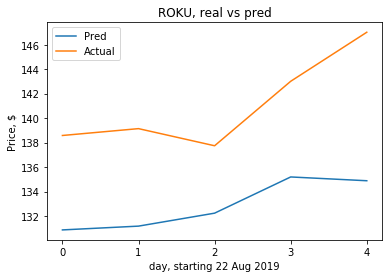

In [50]:
fig = plt.figure()
fig1 = plt.plot(roku_preds)
fig2 = plt.plot(roku_real)
plt.xlabel('day, starting 22 Aug 2019')
plt.ylabel('Price, $')
plt.title('ROKU, real vs pred')
plt.xticks([0,1,2,3,4])
plt.legend((fig1[0], fig2[0]), ('Pred', 'Actual'))

In [19]:
uber_preds = [34.17, 32.0, 33.33, 33.1, 33.47]

In [52]:
uber_real = [34.91, 34.00, 33.43, 33.31, 33.11]

In [66]:
uber_real_loss=33.11/35.29

In [67]:
uber_real_loss

0.9382261263814111

In [64]:
uber_pred_loss=33.47/35.29

In [65]:
uber_pred_loss

0.9484273165202607

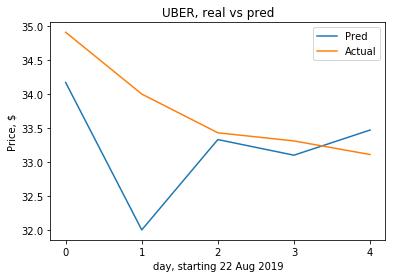

In [53]:
fig = plt.figure()
fig1 = plt.plot(uber_preds)
fig2 = plt.plot(uber_real)
plt.xlabel('day, starting 22 Aug 2019')
plt.ylabel('Price, $')
plt.title('UBER, real vs pred')
plt.xticks([0,1,2,3,4])
plt.legend((fig1[0], fig2[0]), ('Pred', 'Actual'))

In [177]:
my_gain=1719.29 -1739.73

In [178]:
sandp500_gain=2869.99 - 2921.43

In [179]:
my_gain

-20.440000000000055

In [180]:
1719.29/1739.73

0.9882510504503572

In [181]:
sandp500_gain

-51.440000000000055

In [182]:
2869.99/2921.43

0.9823921846492984

# plot DO NOTHING vs S&P500 vs WHAT DID HAPPEN for those 5 days.

In [183]:
sandp500 = [2921.43, 2915.33, 2861.44, 2887.77, 2869.99] # opening prices, 22-28 Aug incl.

In [184]:
mystocks = [1739.73, 1748.82, 1717.26, 1732.59, 1719.29]

In [189]:
two_uber = [2*x for x in uber_real]
two_roku = [2*x for x in roku_real]
done_nothing = [v - two_roku[i] + two_uber[i] + 290 -86.83 for i, v in enumerate(mystocks)]
# magic numbers are added money, cash still in robinhood

In [190]:
done_nothing

[1735.56, 1741.71, 1711.81, 1716.3600000000001, 1694.64]

In [193]:
sum(sandp500)/5

2891.192

In [194]:
2891/(sum(mystocks)/5)

1.6696139501414349

In [195]:
scaled_sandp500 = [x/1.669 for x in sandp500]

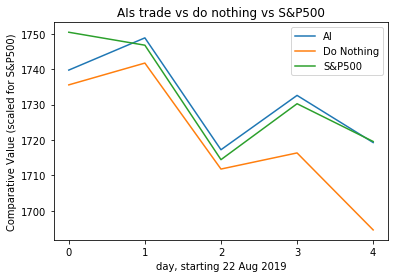

In [197]:
fig = plt.figure()
fig1 = plt.plot(mystocks)
fig2 = plt.plot(done_nothing)
fig3 = plt.plot(scaled_sandp500)
plt.xlabel('day, starting 22 Aug 2019')
plt.ylabel('Comparative Value (scaled for S&P500)')
plt.title('AIs trade vs do nothing vs S&P500')
plt.xticks([0,1,2,3,4])
plt.legend((fig1[0], fig2[0], fig3[0]), ('AI', 'Do Nothing', 'S&P500'))